# Detecting and Categorizing Brick Kilns from Satellite Imagery
> * 🔬 Data Science
* 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction](#Introduction)
* [Export Training Data](#Export-Training-Data)
* [Train the Model](#Train-the-Model)
 * [Load an SingleShotDetector model](#Load-an-SingleShotDetector-model)
 * [Find an Optimal Learning Rate](#Find-an-Optimal-Learning-Rate)
 * [Fit the model](#Fit-the-model)
 * [Save the model](#Save-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
* [Deploy Model and Detect Brick Kilns](#Deploy-Model-and-Detect-Brick-Kilns)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction
With rapid urbanization, demand for bricks is increasing. Brick production is a very large, traditional industry in many parts of Asia. The brick sector in India, although unorganized, is huge in size. India is the second largest producer of bricks in the world — China dominates with 54% share[1].

Brick kilns are a major contributor in air pollution in North India. Production of bricks leads to emission of harmful gases and particulate matter, including toxic elements such as carbon monoxides and oxides of Sulphur (SOx). Exposure to these emissions is extremely hazardous to health and can impact physical and mental growth of children.

Most of the brick kilns in India are of the Fixed Chimney Bull’s Trench Kilns (FCBTK) type. However, there is a newer design of kilns, known as the Zigzag kiln, which is more energy efficient and causes much lesser air pollution. The older design kilns can be converted into the Zigzag design leading to increase in efficiency — however, there is an cost involved in retrofitting and this is leading to slower adoption of this technology.

Central Pollution Control Board (CPCB) issued a directive in June 2017 mandating brick kilns across India to convert to the less polluting zigzag setting design. This directive clearly stated that brick kilns operating without permission would be shut down [2]. Despite the directive, there are many brick kilns that are still operating without following the prescribed design norms.

In this sample, we will use Deep Learning on ArcGIS Platform to detect the location and design category of all brick kilns around Delhi NCR area in India to find the brick kilns which are not following the directions from CPCB. Deep Learning is a tried and tested method for object detection on satellite imagery and high level steps that we will follow are:

* Collect Data using ArcGIS Pro
* Train Deep Learning model using arcgis.learn
* Deploy the trained model using ArcGIS Pro


>We will be using the ESRI World Imagery basemap layer to train the model, and we will be applying on a different area to verify our results.


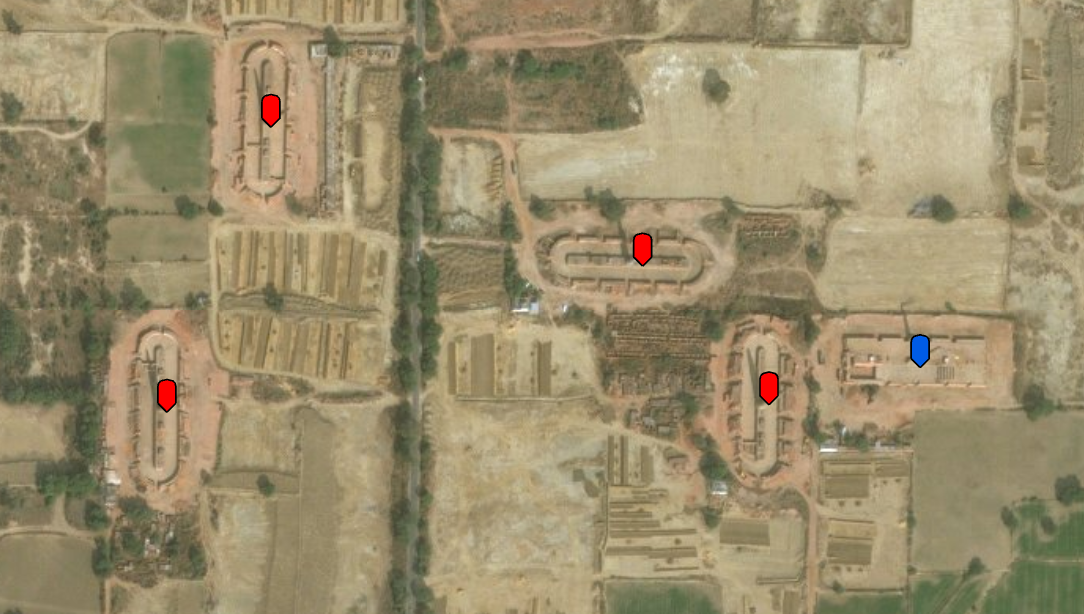

<center>A subset of training data.</center>

On the above image we can see **Zig-Zag shaped brick kilns** (Blue Marker) and **oval shaped brick kilns** (Red Marker).
  

<br>
  
<br>

## Collecting training data

We will be using ArcGIS Pro to mark locations of the two types of brick kilns on the Esri World Imagery. We will create a point feature class representing locations of brick kiln and set an attribute field indicating it’s type (0=FCBTK/Oval design. 1=Zigzag/Rectangular). To simplify our job we will only mark the center locations of the kilns — we’re only interested in their location and not the precise size.


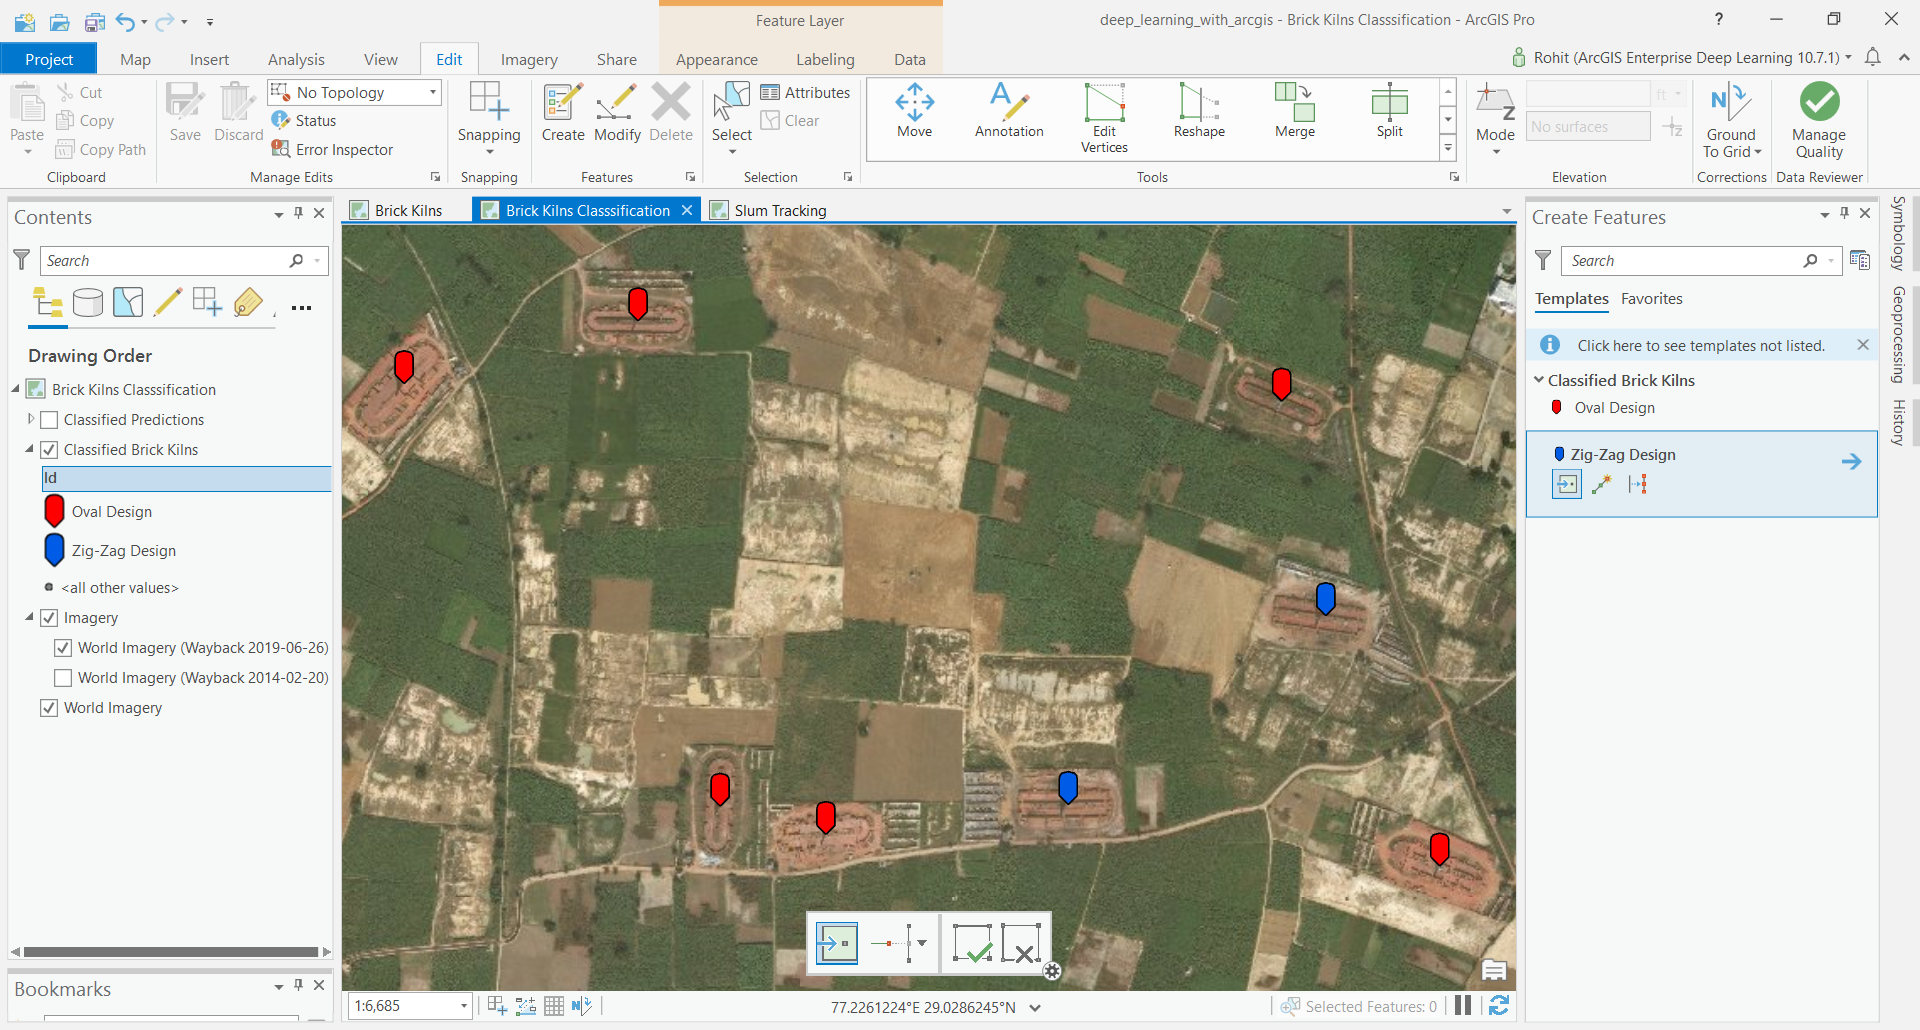

## Export Training Data

Training data can be exported by using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](#"https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm") as well as [ArcGIS Enterprise](#"https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm").

- **Input Raster**: ESRI World Imagery
- **Input Feature Class Or Classified Raster**: brick kilns layer
- **Class Value Field**: field containing **0** for oval shaped brick kiln and **1** for zig-zag shaped brick kiln
- **Buffer Radius**: 75 Meter
- **Tile Size X** & **Tile Size Y**: 256
- **Meta Data Format**: 'Pascal Visual Object Classes' as we are training an Object Detection Model which in this case is `SingleShotDetector`.
- In 'Environments' tab set an optimum 'Cell Size' which can accommodate two brick kilns in a single tile. For this sample we will be setting tile size to **256 px** and Cell Size to **1 meter**.

Tool Reference for [ArcGIS Pro](#"https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm") and [ArcGIS Enterprise](#"https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm")


<div>
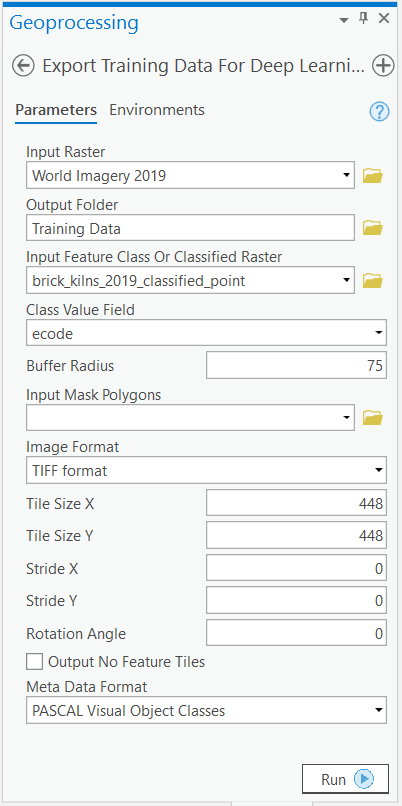
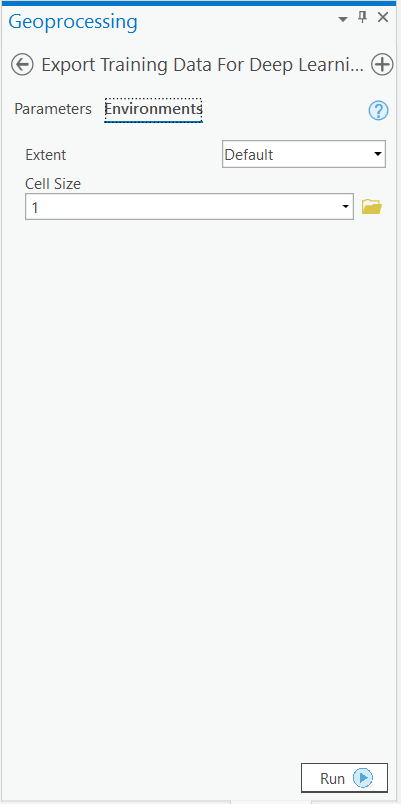
</div>

## Train the Model
We will train our model using `arcgis.learn` module within ArcGIS API for Python. `arcgis.learn` contains tools and deep learning capabilities required for this study. A detailed documentation to install and setup the environment is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/).

### Necessary Imports

In [4]:
from arcgis.learn import SingleShotDetector, prepare_data

### Prepare Data

We will now use the `prepare_data()` function to apply various types of transformations and augmentations on the training data. These augemntations enable us to train a better model with limited data and also prevent the model from overfitting. `prepare_data()` takes 3 parameters.
<br>`path`: path of folder containing training data.
<br>`chip_size`: Same as per specified while exporting training data.
<br>`batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card and the type of model which you are working with. For this sample a batch size of **64** worked for us on a GPU with 11GB memory.

This function will return a fast.ai databunch, we will use this in the next step to train a model.

In [5]:
data = prepare_data(path=r'C:\Workspace\Tasks\Task 63 - Csag Workshop 2020-01-22\Deep Learning with ArcGIS\for sharing\Deep Learning with ArcGIS\Hands on\EX2 - Brick Kilns Detection\training_data_brick_kilns_256px_1m', 
                    batch_size=64)

#### Visualize a few samples from your Training data
To make sense of training data we will use the `show_batch()` method in `arcgis.learn`. `show_batch()` randomly picks few samples from the training data and visualizes them.

`rows`: No of rows we want to see the results for.

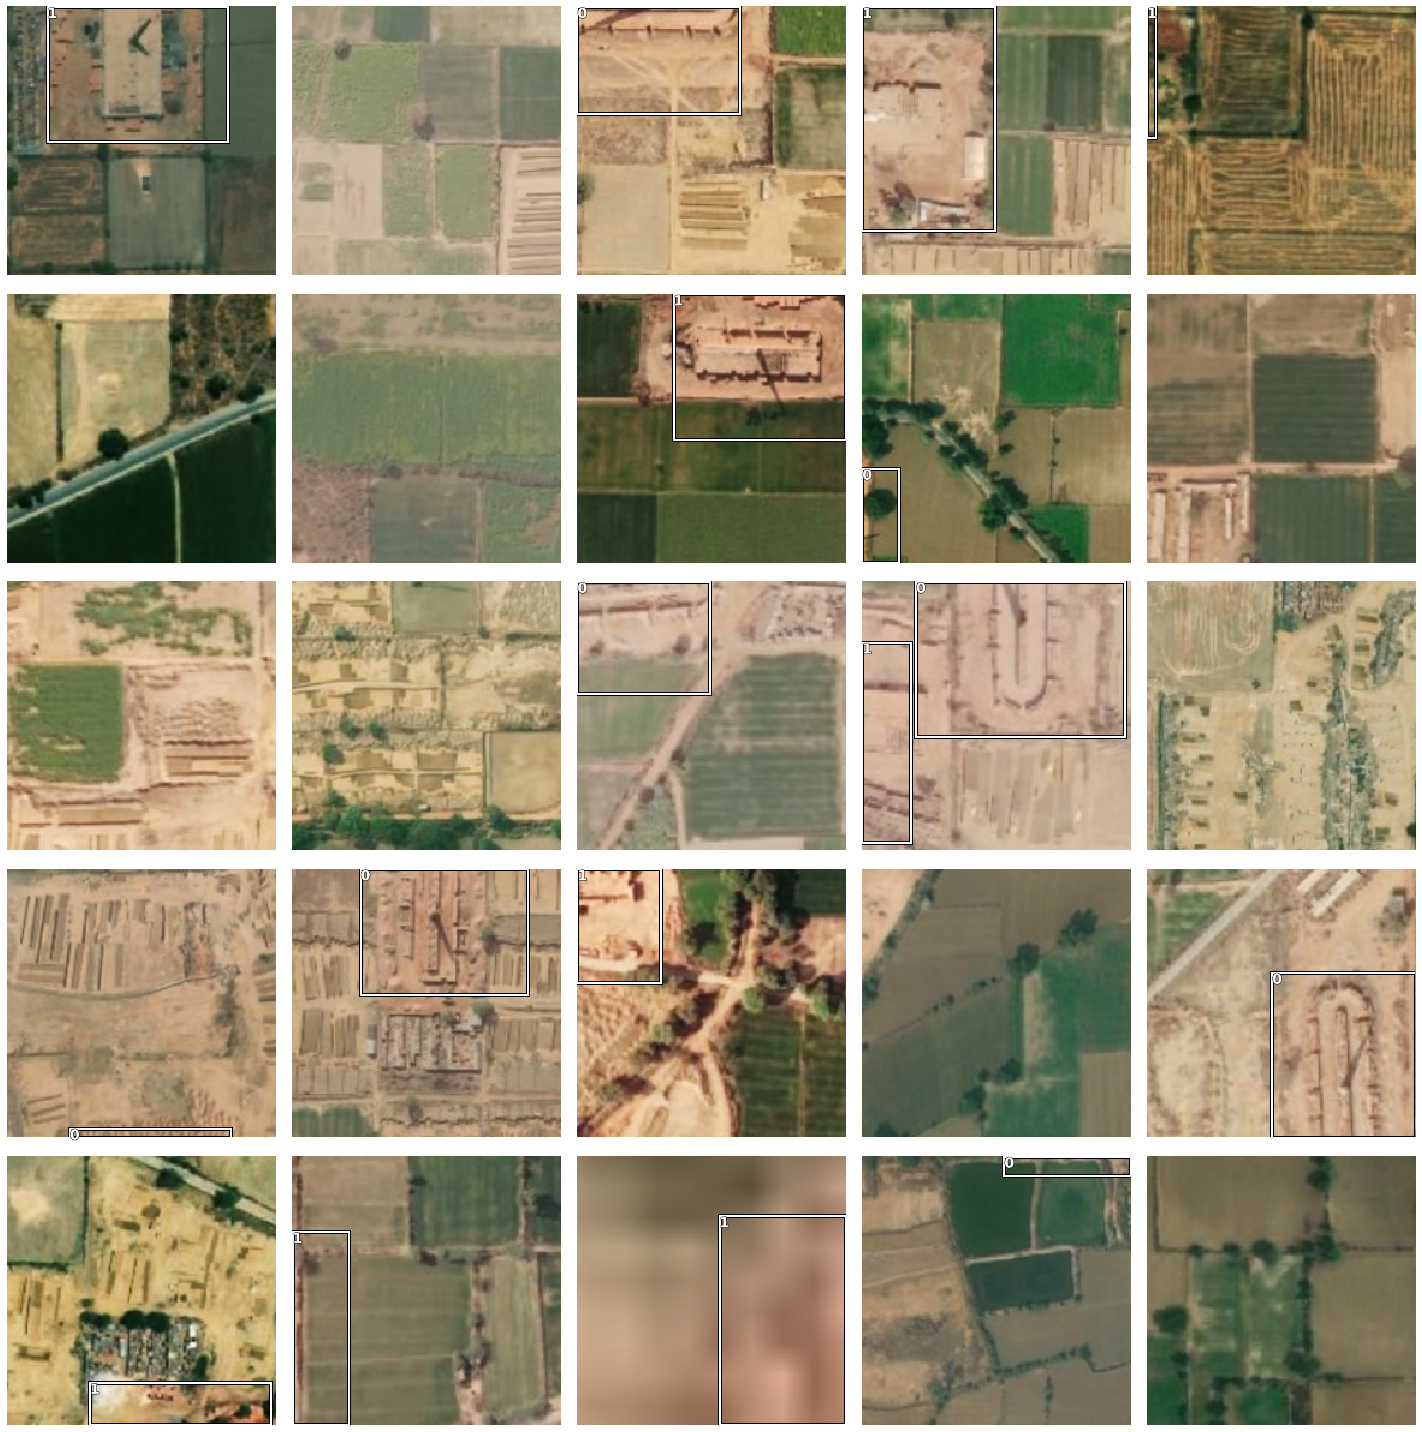

In [6]:
data.show_batch(rows=5)

<center>Some random samples from our training data have been visualized above.</center>

The imagery chips above have the bounding boxes of brick kilns marked out. Boxes with 0 as label are oval shaped (FCBTK) brick kilns and the ones with 1 as label are Zigzag ones.

### Load a SingleShotDetector model

The Code below instantiates a `SingleShotDetector` model,  it is based on a popular object detection model that’s better known by it’s abbreviated form — 'SSD'. The output from the model returns the type and bounding boxes of detected features. 
This type of model is used in an '**object detection**' or in GIS terminology '**feature extraction**' task, by default this model will be loaded on a pretrained 'resnet' backbone. 

In [7]:
model = SingleShotDetector(data)

### Find an Optimal Learning Rate
A newly initialized deep learning model is like the brain of a child that’s just born. It doesn’t know anything to start with, and learns by looking at several examples of objects that it needs to learn to recognize. If it learns at a very slow rate, it will take ages before it learn anything. On the other hand, if the child is quick to jump to conclusions (or, has a ‘high learning rate’ in deep learning terminology), it will often learn wrong things and that’s no good either.

Similarly, deep learning models need to be initialized with a learning rate. This is an important hyperparameter whose value should be set before the learning process begins [3]. Learning rate is a key parameter that determines how we adjust weights for our network with respect to loss gradient [4].

arcgis.learn leverages fast.ai’s learning rate finder to find an optimum learning rate for training models. We can use the lr_find() method to find the optimum learning rate at which can train a roboust model fast enough.


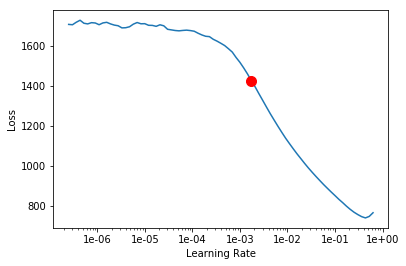

0.001737800828749376

In [5]:
model.lr_find()

Based on the learning rate plot above, we can see that the learning rate suggested by lr_find() for our training data is 1e-03. We can use it to train our model. In the latest release of arcgis.learn we can train models without even specifying a learning rate. That internally uses the learning rate finder to find an optimal learning rate and uses it.

### Fit the model

To train the model, we use the fit() method. To start, we will use 10 epochs to train our model. Epoch defines how many times model is exposed to entire training set.


In [10]:
model.fit(epochs=10, lr=0.002, checkpoint=False)

Training data is split into training set and validation set at the [Prepare Data step](#Prepare-Data). By default training vs validation set proportion is 80% & 20%. Output of `fit()` method gives us the loss on training and validation sets. This helps us to assess the generalization capability of the model on unseen data and prevent overfitting. Here, with only 10 epochs, we are see reasonable results — both training and validation losses have gone down considerably indicating that the model is learning to recognize the brick kilns.

Next step is to save the model for further training or inference later. By default, model will be saved into data path specified in the beginning of this notebook.

### Save the model

We will save the model which we trained as a '**Deep Learning Package**' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default it will be saved to the '**models**' sub-folder within our training data folder.

In [14]:
model.save('10e')

WindowsPath('C:/Workspace/Tasks/Task 63 - Csag Workshop 2020-01-22/Deep Learning with ArcGIS/for sharing/Deep Learning with ArcGIS/Hands on/EX2 - Brick Kilns Detection/training_data_brick_kilns_256px_1m/models/10e')

### Load an Intermediate model to train it further

To retrain a saved model, we can load it again using the code below and train it further as explained above.

In [15]:
# model.load('ssd_brick-kiln_01')

### Visualize results in validation set

Its a good practice to see results of the model viz-a-viz ground truth. The code below picks a random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

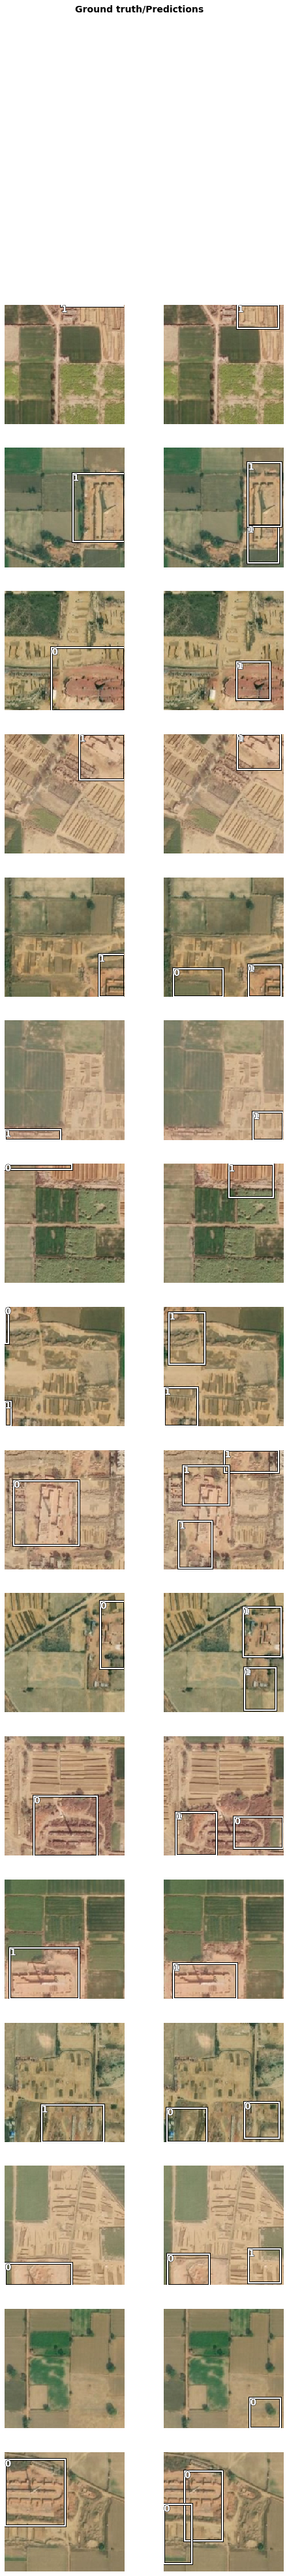

In [17]:
model.show_results(rows=16, thresh=0.2)

Here a subset of ground truth from training data is visualized along with the predictions from the model. As we can see, our model is performing well and the predictions are comparable to the ground truth.


## Deploy Model and Detect Brick Kilns

We will use saved model to detect objects using '**Detect Objects Using Deep Learning**' tool available in both [**ArcGIS Pro**](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) and [**ArcGIS Enterprise**](https://developers.arcgis.com/rest/services-reference/detect-objects-using-deep-learning.htm). For this sample we will use ESRI World Imagery basemap to detect brick kilns.

- **Input Raster**: ESRI World Imagery
- **Output Detect Objects**: brick_kilns_prediction_2014
- **Model Definition**: model.emd
- **padding**: The 'Input Raster' is tiled and the deep learning model runs on each individual tile separately before producing the final 'detected objects feature class'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to detect objects accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better. 
- **threshold**:0.1
- **nms_overlap**: 0.1
- **Cell Size**: Should be close to at which we trained the model, we specified that at the [Export Training Data step]("#Export-Training-Data") .


Tool Reference [here](#"https://pro.arcgis.com/en/pro-app/tool-reference/raster-analysis/detect-objects-using-deep-learning.htm")


<div>
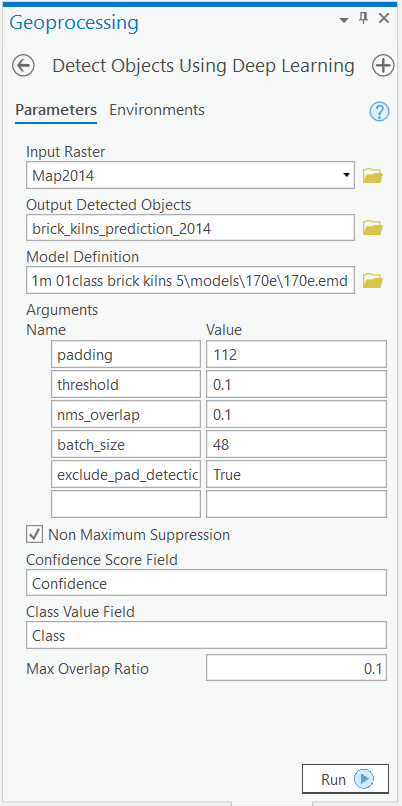
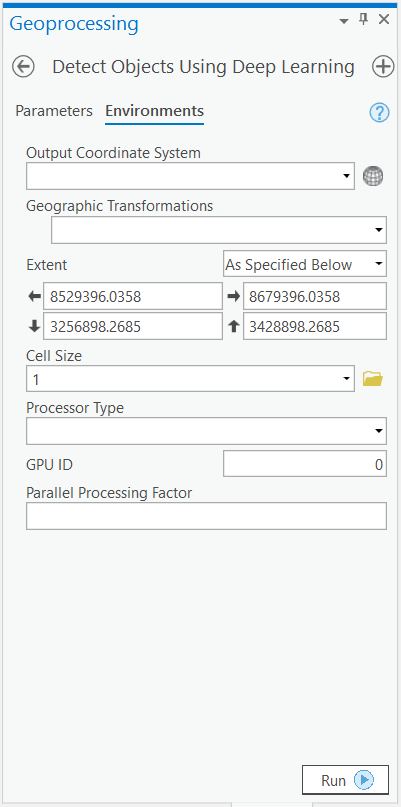
</div>

```python
arcpy.ia.DetectObjectsUsingDeepLearning("Imagery", r"C:\sample\sample.gdb\brick_kilns_prediction", r"C:\sample\data\training data 448px 1m\models\best_model\best_model.emd", "padding 112;threshold 0.1;nms_overlap 0.1;batch_size 48;exclude_pad_detections True", "NO_NMS", "Confidence", "Class", 0)
```


`Detect Objects Using Deep Learning` returns a feature class that can be further refined using the [Definition query](https://pro.arcgis.com/en/pro-app/help/mapping/layer-properties/definition-query.htm) and [Non Maximum Suppression tool](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/non-maximum-suppression.htm) tool. We have publish the output from this sample here as a [hosted feature layer](https://geosaurus.maps.arcgis.com/home/webmap/viewer.html?webmap=711b1725f6334aeca2151734b37d3c50).

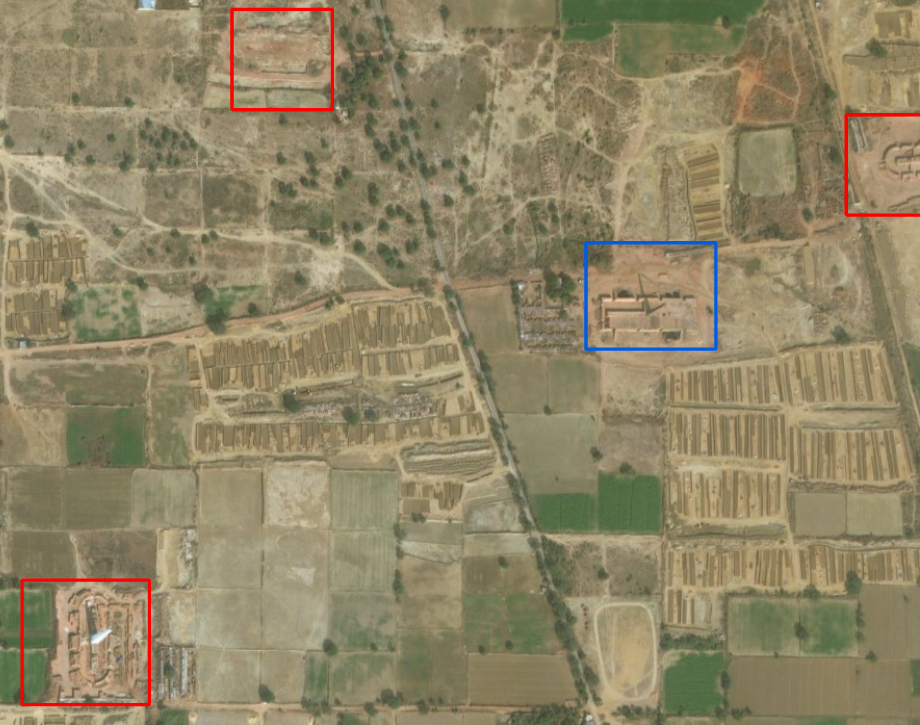

<center>A subset of detected Brick Kilns.</center>

## Conclusion
In this notebook, we have covered a lot of ground. We discussed how to export training data for deep learning and what the output looks like. We also demonstrated how to prepare the input data, train a object Identification model, visualize the results, as well as apply the model to an unseen image.


## References




[1] Sheikh, Afeefa. (2014). Brick kilns: Cause of Atmospheric Pollution. 

[2] https://www.cseindia.org/content/downloadreports/9387

[3] https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)

[4] https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10